In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
print('torch version %s and torchvision version %s' % (torch.__version__,
                                                       torchvision.__version__))

torch version 1.5.0 and torchvision version 0.6.0


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Set global parameter
DATA_DIR = '../../ref/dlg/data/'
EXP_DIR = '../../exp/'
IMAGE_IDX = 10
SEED = 30 # 42, 97

In [3]:
def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

In [4]:
def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [5]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act())
        self.fc = nn.Sequential(nn.Linear(768, 100))
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

In [7]:
# Set device
device = 'cuda' if torch.cuda.is_available else 'cpu'
print('Running on %s' % device)

# Get dataset and define transformations
dst = datasets.CIFAR100(DATA_DIR, download=True)
tp = transforms.Compose([transforms.Resize(32),
                         transforms.CenterCrop(32),
                         transforms.ToTensor()])
tt = transforms.ToPILImage()

# Construct model and intiaize weights
net = LeNet().to(device)
net.apply(weights_init)

# Define criterion
criterion = cross_entropy_for_onehot

# Get attack data and label
gt_data = tp(dst[IMAGE_IDX][0]).to(device)
gt_data = gt_data.view(1, *gt_data.size())
gt_image = tt(gt_data[0].cpu())
gt_label = torch.Tensor([dst[IMAGE_IDX][1]]).long().to(device)
gt_label = gt_label.view(1,)
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

# Compute original gradient 
out = net(gt_data)
y = criterion(out, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

# Share the gradients with other clients
original_dy_dx = list((_.detach().clone() for _ in dy_dx))

# Generate dummy data and label
torch.manual_seed(SEED)
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

dummy_init_image = tt(dummy_data[0].cpu())
dummy_init_label = torch.argmax(dummy_label, dim=-1)

Running on cuda
Files already downloaded and verified


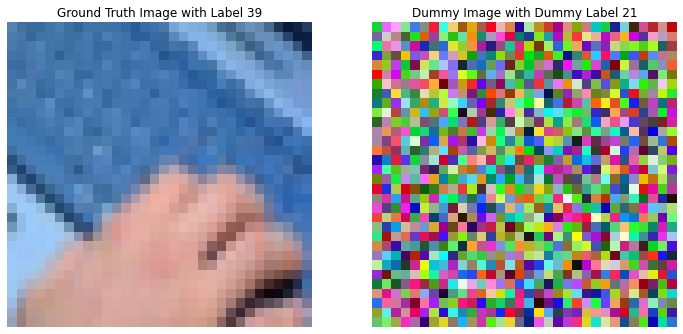

In [8]:
fig = plt.figure(figsize=(12, 8))
gt_ax = plt.subplot(121)
gt_ax.imshow(gt_image)
gt_ax.set_title('Ground Truth Image with Label %d' % gt_label.item())
gt_ax.axis('off')

dummy_ax = plt.subplot(122)
dummy_ax.imshow(tt(dummy_data[0].cpu()))
dummy_ax.set_title('Dummy Image with Dummy Label %d' % torch.argmax(dummy_label, dim=-1).item())
dummy_ax.axis('off')

fig.show()

In [9]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )


dummy_grads = []
dummy_lbfgs_num_iter = []
history = []

for iters in range(300):

    closure_grads = []
    def closure():
        optimizer.zero_grad()

        pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_loss = criterion(pred, dummy_onehot_label)
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0

        for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
            grad_diff += ((gx - gy) ** 2).sum()
            grad_count += gx.nelement()
        # grad_diff = grad_diff / grad_count * 1000

        closure_grads.append(dummy_dy_dx)
        grad_diff.backward()
        return grad_diff
    
    optimizer.step(closure)
    dummy_grads.append(closure_grads[-1])
    dummy_lbfgs_num_iter.append(len(closure_grads))
    history.append([tt(dummy_data[0].cpu()),
                    torch.argmax(dummy_label, dim=-1).item()])

    if iters % 10 == 0: 
        current_loss = closure()
        print('%3d %2.6f' % (iters, current_loss.item()))
        if current_loss.item() < 1e-5:
            break

  0 38.029247
 10 2.655078
 20 0.565394
 30 0.141609
 40 0.035977
 50 0.010596
 60 0.003620
 70 0.001526
 80 0.000710
 90 0.000323
100 0.000156
110 0.000075
120 0.000036
130 0.000019
140 0.000011
150 0.000007


In [10]:
compute_l2norm = lambda x: (x ** 2).sum().item() ** 0.5
compute_min = lambda x: x.min().item()
compute_max = lambda x: x.max().item()
compute_mean = lambda x: x.mean().item()
compute_median = lambda x: x.median().item()

In [11]:
original_grads_norm = [compute_l2norm(e) for e in original_dy_dx]
original_grads_min = [compute_min(e) for e in original_dy_dx]
original_grads_max = [compute_max(e) for e in original_dy_dx]
original_grads_mean = [compute_mean(e) for e in original_dy_dx]
original_grads_median = [compute_median(e) for e in original_dy_dx]

In [12]:
dummy_grads_norm = np.array([[compute_l2norm(e) for e in r] for r in dummy_grads])
dummy_grads_min = np.array([[compute_min(e) for e in r] for r in dummy_grads])
dummy_grads_max = np.array([[compute_max(e) for e in r] for r in dummy_grads])
dummy_grads_mean = np.array([[compute_mean(e) for e in r] for r in dummy_grads])
dummy_grads_median = np.array([[compute_median(e) for e in r] for r in dummy_grads])

In [13]:
def plot_history(gt, di, history, title, cols=6, log_interval=10, fig_path=None):
    rows = (len(history) + 2) // (cols * log_interval) + 1
    fig, axes = plt.subplots(rows, cols, figsize=(15, 2.5*rows+1.5), constrained_layout=True)
    fig.suptitle(title, fontsize=18)
    
    # Plot ground truth and dummy initial image and label, respectively
    axes[0, 0].imshow(gt[0])
    axes[0, 0].set_title('GT Image with Label %d' % gt[1].item())
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(di[0])
    axes[0, 1].set_title('Dummy Init with Label %d' % di[1].item())
    axes[0, 1].axis('off')

    for i in range(0, len(history), log_interval):
        i_log = i // log_interval + 2
        axes[i_log // cols, i_log % cols].imshow(history[i][0])
        axes[i_log // cols, i_log % cols].set_title(
            'Iter {:<3d} with label {:d}'.format(i, history[i][1]))
        axes[i_log // cols, i_log % cols].axis('off')
    
    # Delete empty axes
    for i in range(i_log%cols+1, cols):
        fig.delaxes(axes[i_log // cols, i])
    
    # Save figure
    if fig_path is not None:
        fig.savefig(fig_path, bbox_inches='tight')
    fig.show()

In [14]:
def plot_convergency_curve(grads_index, original_index, title, fig_path=None):
    fig, axes = plt.subplots(2, 5, figsize=(16, 9), constrained_layout=True)
    fig.suptitle(title, fontsize=18)

    for i in range(10):
        axes[i // 5, i % 5].plot(grads_index[:, i], color='b')
        axes[i // 5, i % 5].axhline(original_index[i], color='r')
    
    # Save figure
    if fig_path is not None:
        fig.savefig(fig_path, bbox_inches='tight')
    fig.show()

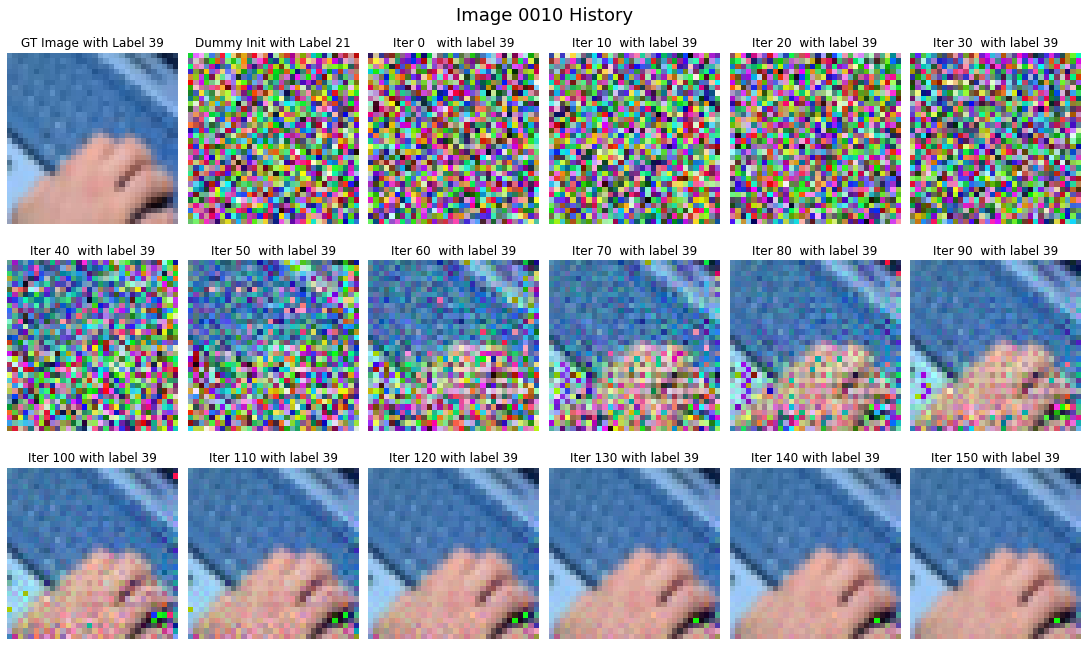

In [15]:
plot_history([gt_image, gt_label], [dummy_init_image, dummy_init_label], history,
             title='Image %04d History' % IMAGE_IDX,
             fig_path='%04d_history.png' % IMAGE_IDX)

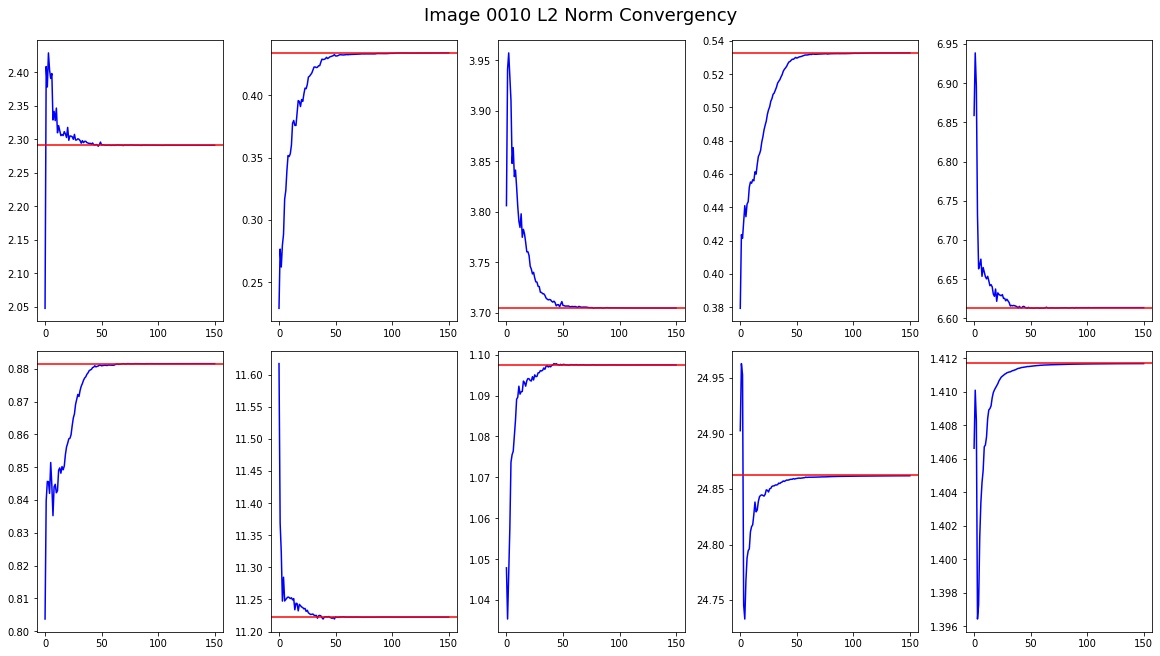

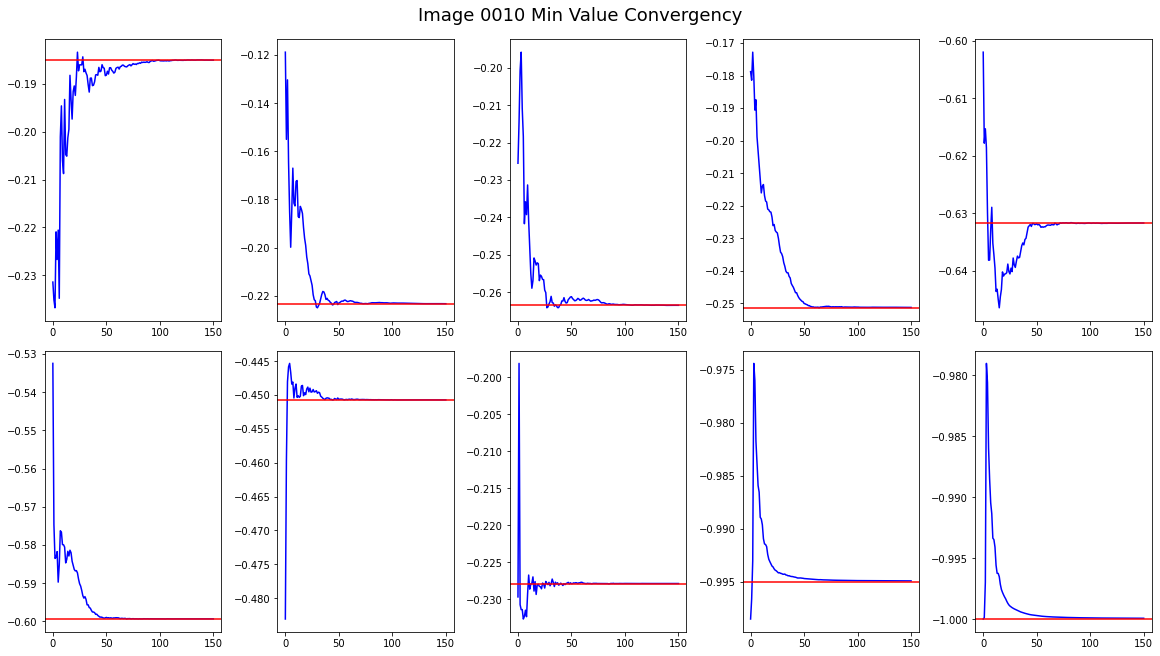

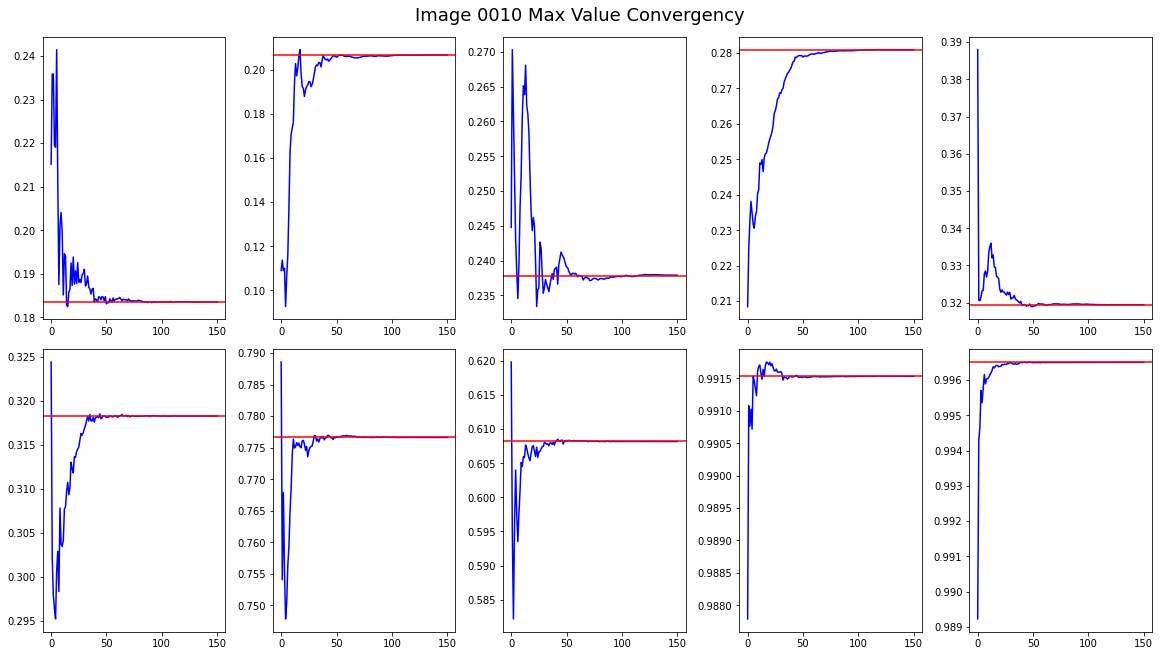

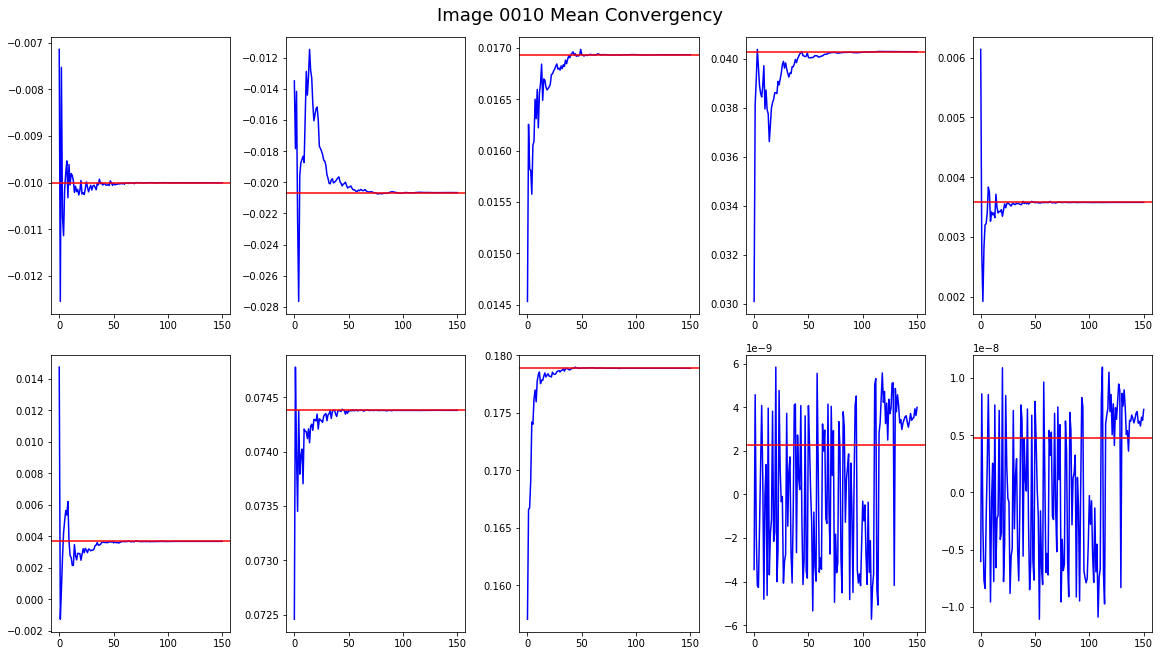

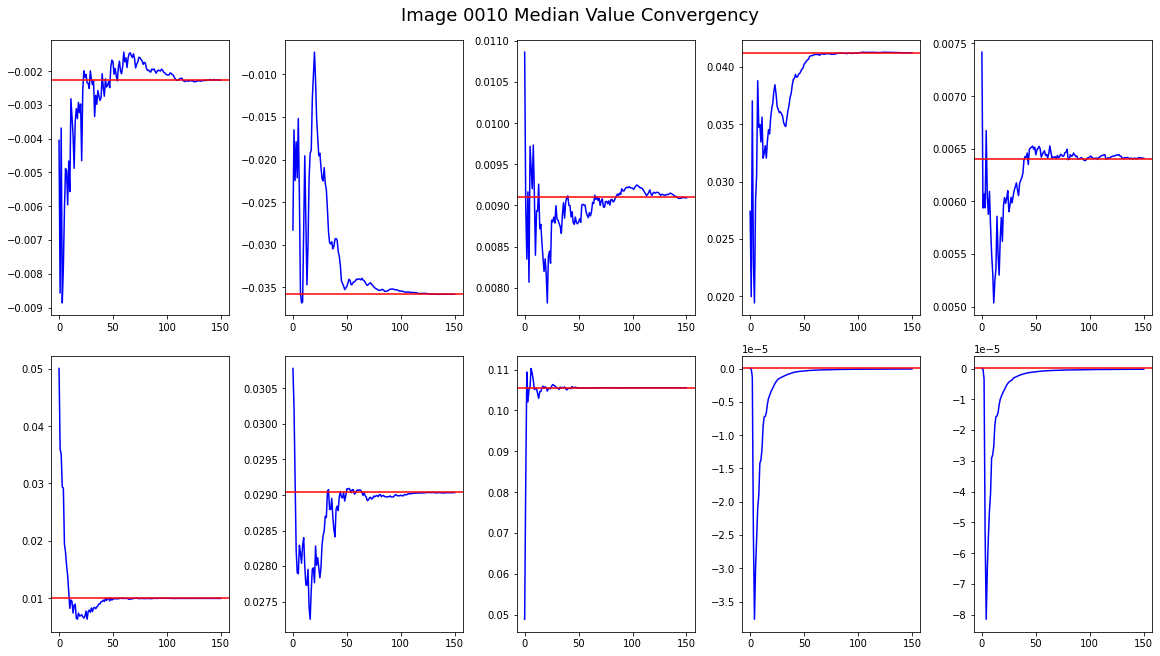

In [16]:
plot_convergency_curve(dummy_grads_norm, original_grads_norm,
                       title='Image %04d L2 Norm Convergency' % IMAGE_IDX,
                       fig_path='%04d_l2norm.png' % IMAGE_IDX)

plot_convergency_curve(dummy_grads_min, original_grads_min,
                       title='Image %04d Min Value Convergency' % IMAGE_IDX,
                       fig_path='%04d_min.png' % IMAGE_IDX)

plot_convergency_curve(dummy_grads_max, original_grads_max,
                       title='Image %04d Max Value Convergency' % IMAGE_IDX,
                       fig_path='%04d_max.png' % IMAGE_IDX)

plot_convergency_curve(dummy_grads_mean, original_grads_mean,
                       title='Image %04d Mean Convergency' % IMAGE_IDX,
                       fig_path='%04d_mean.png' % IMAGE_IDX)

plot_convergency_curve(dummy_grads_median, original_grads_median,
                       title='Image %04d Median Value Convergency' % IMAGE_IDX,
                       fig_path='%04d_median.png' % IMAGE_IDX)